In [1]:
# Import Required Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Define URLs for the datasets
url_deaths = 'https://raw.githubusercontent.com/khoocheeshin/HIAGroupProject/refs/heads/main/deaths_malaysia.csv'
url_cases = 'https://raw.githubusercontent.com/khoocheeshin/HIAGroupProject/refs/heads/main/cases_malaysia.csv'
url_tests = 'https://raw.githubusercontent.com/khoocheeshin/HIAGroupProject/refs/heads/main/tests_malaysia.csv'

# Load datasets from URLs
deaths_data = pd.read_csv(url_deaths)
cases_data = pd.read_csv(url_cases)
tests_data = pd.read_csv(url_tests)

# Display basic info for each dataset
datasets = {'Deaths': deaths_data, 'Cases': cases_data, 'Tests': tests_data}

print("Dataset Information:")
for name, data in datasets.items():
    print(f"\n{name} Dataset Info:")
    print(data.info())
    print("\nMissing Values:")
    print(data.isna().sum())
    print("\nSample Rows:")
    print(data.head())

# Overview Summary
print("\nKey Observations:")
print("- Deaths Data: Includes daily deaths by vaccination status and related trends.")
print("- Cases Data: Includes daily new infections and demographics.")
print("- Tests Data: Includes testing counts for RTK-Ag and PCR tests.")

Dataset Information:

Deaths Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1720 entries, 0 to 1719
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   date            1720 non-null   object
 1   deaths_new      1720 non-null   int64 
 2   deaths_bid      1720 non-null   int64 
 3   deaths_new_dod  1720 non-null   int64 
 4   deaths_bid_dod  1720 non-null   int64 
 5   deaths_unvax    1720 non-null   int64 
 6   deaths_pvax     1720 non-null   int64 
 7   deaths_fvax     1720 non-null   int64 
 8   deaths_boost    1720 non-null   int64 
 9   deaths_tat      1720 non-null   int64 
dtypes: int64(9), object(1)
memory usage: 134.5+ KB
None

Missing Values:
date              0
deaths_new        0
deaths_bid        0
deaths_new_dod    0
deaths_bid_dod    0
deaths_unvax      0
deaths_pvax       0
deaths_fvax       0
deaths_boost      0
deaths_tat        0
dtype: int64

Sample Rows:
         date  deaths

In [2]:
# Convert dates to datetime
deaths_data['date'] = pd.to_datetime(deaths_data['date'])
cases_data['date'] = pd.to_datetime(cases_data['date'])
tests_data['date'] = pd.to_datetime(tests_data['date'])

# Merge all datasets together
merged_data = deaths_data.merge(cases_data, on='date', how='inner')
merged_data = merged_data.merge(tests_data, on='date', how='inner')

# Handle missing data
merged_data.fillna(0, inplace=True)

# Add derived metrics
merged_data['cfr'] = (merged_data['deaths_new'] / merged_data['cases_new']).fillna(0) * 100
merged_data['positivity_rate'] = (merged_data['cases_new'] / (merged_data['rtk-ag'] + merged_data['pcr'])).fillna(0) * 100

# Create COVID-19 phases
merged_data['phase'] = pd.cut(
    merged_data['date'],
    bins=[
        pd.Timestamp('2021-04-01'),
        pd.Timestamp('2022-01-31'),
        pd.Timestamp('2022-04-30'),
        pd.Timestamp('2024-11-30')
    ],
    labels=['Delta', 'Omicron', 'Endemic'],
    right=True
)

# Save the cleaned data for reuse
merged_data.to_csv('filtered_data.csv', index=False)

# Display data summary
print("\nSample Data:")
print(merged_data.head())


Sample Data:
        date  deaths_new  deaths_bid  deaths_new_dod  deaths_bid_dod  \
0 2020-03-17           2           0               2               0   
1 2020-03-18           0           0               0               0   
2 2020-03-19           0           0               0               0   
3 2020-03-20           1           0               1               0   
4 2020-03-21           4           0               4               0   

   deaths_unvax  deaths_pvax  deaths_fvax  deaths_boost  deaths_tat  ...  \
0             2            0            0             0           0  ...   
1             0            0            0             0           0  ...   
2             0            0            0             0           0  ...   
3             1            0            0             0           0  ...   
4             4            0            0             0           0  ...   

   cluster_community  cluster_highRisk  cluster_education  \
0                0.0               

In [3]:
# Load prepared data
filtered_data = pd.read_csv('filtered_data.csv')

# Descriptive statistics
print("\nDescriptive Statistics:")
print(filtered_data[['deaths_new', 'cases_new', 'cfr', 'positivity_rate']].describe())


Descriptive Statistics:
        deaths_new     cases_new          cfr  positivity_rate
count  1707.000000   1707.000000  1707.000000      1707.000000
mean     21.881078   3117.156415     0.480562         7.258469
std      59.019156   5630.282331     1.439568         6.471898
min       0.000000      1.000000     0.000000         0.014158
25%       0.000000    141.500000     0.000000         2.905573
50%       2.000000    862.000000     0.190295         5.430464
75%       9.000000   3265.500000     0.606061        10.007149
max     592.000000  33406.000000    50.000000        69.696970


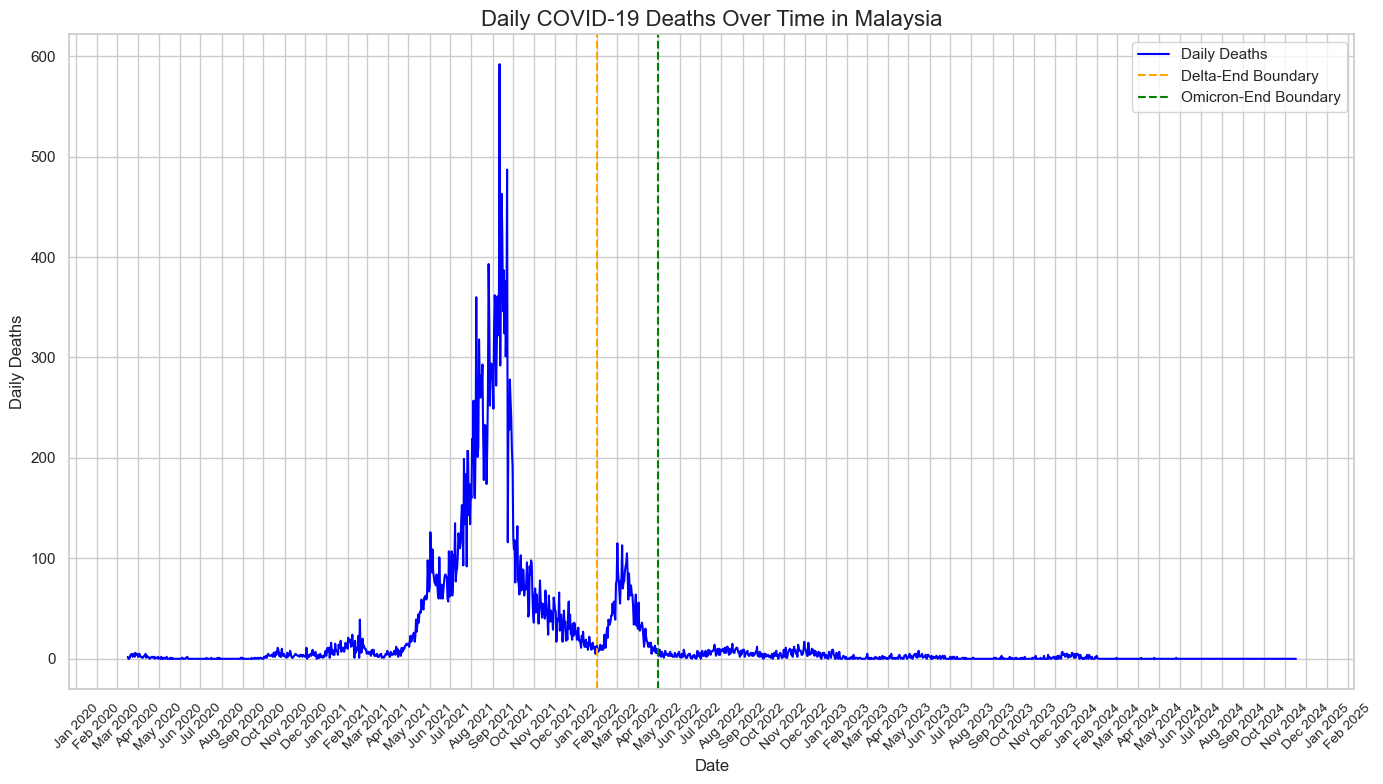

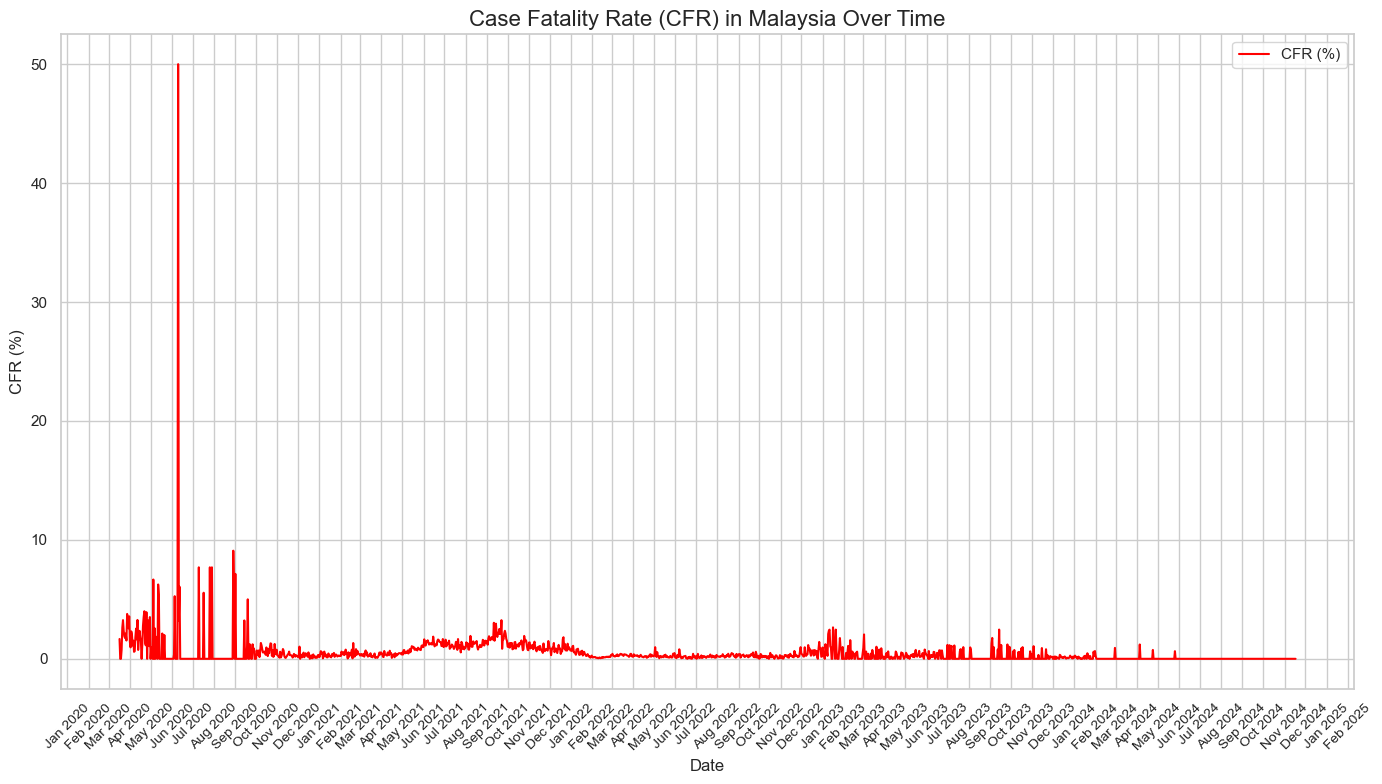

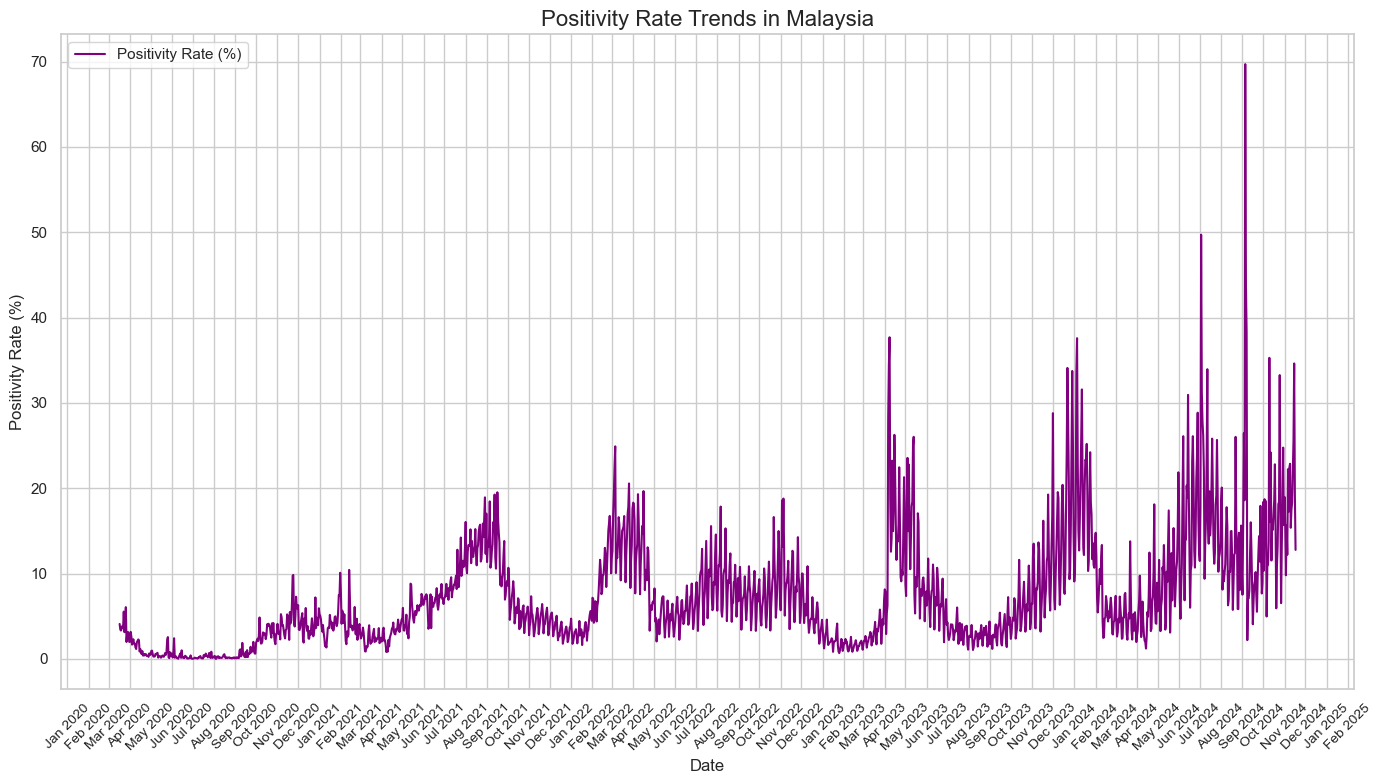

In [4]:
# Set Seaborn style for better visualization
sns.set(style="whitegrid")
# Convert date to datetime
filtered_data['date'] = pd.to_datetime(filtered_data['date'])

# Visualize daily deaths trend
plt.figure(figsize=(14, 8))
sns.lineplot(data=filtered_data, x='date', y='deaths_new', label='Daily Deaths', color='blue')
plt.axvline(mdates.date2num(pd.Timestamp('2022-01-31')), color='orange', linestyle='--', label='Delta-End Boundary')
plt.axvline(mdates.date2num(pd.Timestamp('2022-04-30')), color='green', linestyle='--', label='Omicron-End Boundary')
plt.xticks(rotation=45, fontsize=10)
plt.title("Daily COVID-19 Deaths Over Time in Malaysia", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Daily Deaths", fontsize=12)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y')) 
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  
plt.xticks(rotation=45, fontsize=10) 
plt.legend()
plt.tight_layout()
plt.show()

# Visualize CFR over time
plt.figure(figsize=(14, 8))
sns.lineplot(data=filtered_data, x='date', y='cfr', label='CFR (%)', color='red')
plt.title("Case Fatality Rate (CFR) in Malaysia Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("CFR (%)", fontsize=12)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y')) 
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()

# Visualize positivity rate trends
plt.figure(figsize=(14, 8))
sns.lineplot(data=filtered_data, x='date', y='positivity_rate', label='Positivity Rate (%)', color='purple')
plt.title("Positivity Rate Trends in Malaysia", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Positivity Rate (%)", fontsize=12)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y')) 
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()

In [5]:
# Create summary table
summary_table = filtered_data[['phase', 'deaths_new', 'cfr', 'positivity_rate']].groupby('phase').agg(
    total_deaths=('deaths_new', 'sum'),
    average_cfr=('cfr', 'mean'),
    average_positivity_rate=('positivity_rate', 'mean')
).reset_index()

print("\nPhase-Wise Summary Table:")
print(summary_table)

# Save summary table
summary_table.to_csv('summary_table.csv', index=False)


Phase-Wise Summary Table:
     phase  total_deaths  average_cfr  average_positivity_rate
0    Delta         30700     1.017865                 6.782124
1  Endemic          1804     0.186727                 9.031827
2  Omicron          3569     0.222450                12.059644
